# Load Required Packages 

In [2]:
import os,sys
import pandas as pd
import scipy.io
import numpy as np 
from scipy.spatial.distance import pdist
import time 
import math
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn import ensemble
from sklearn.metrics import accuracy_score, make_scorer, classification_report
from statistics import mean
from sklearn.ensemble import GradientBoostingClassifier
import PIL
from PIL import Image
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV
from keras.layers import Dense, Activation, Flatten, Input, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


# Part I Baseline Model: GBM

### 1. Provide directories for training/testing images.

In [15]:
root = sys.path[0]
train_dir =  os.path.join(root,  '../data/train_set')  
train_image_dir =  os.path.join(train_dir, 'images')
train_pt_dir =  os.path.join(train_dir, 'points' )
train_label_path =  os.path.join(train_dir,  "label.csv")

###  2. Train/Test Split Feature Extraction

In [16]:
info = pd.read_csv(train_label_path)
# read mat file and store coordinates in mat 
m = []
for idx in info['Index']: 
    file = "%04d.mat"%(idx)
    m.append( scipy.io.loadmat( os.path.join( train_pt_dir, file ) ))

mat = [x[[i for i in x.keys() if not i in ['__header__', '__version__', '__globals__']][0]] for x in m]
c = np.array([pdist(x) for x in mat[0:]])

In [17]:
train_idx, test_idx = train_test_split(info['Index'], test_size=0.2, random_state=123)

In [18]:
start_time_test=time.time()
train_features=np.array([pdist(mat[i-1]) for i in train_idx ])
print("baseline train features extracting takes %s seconds" % round((time.time() - start_time_test),3))
start_time_train=time.time()
test_features=np.array(([pdist(mat[i-1]) for i in test_idx ]))
print("base line test features extracting takes %s seconds" % round((time.time() - start_time_train),3))
train_labels=info.emotion_idx[train_idx-1]
test_labels=info.emotion_idx[test_idx-1]
print(train_features.shape,train_labels.shape)

baseline train features extracting takes 0.121 seconds
base line test features extracting takes 0.027 seconds
(2000, 3003) (2000,)


###  3. Train a Baseline GBM model with training features and responses

In [63]:
#baseline GBM

baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
start_time=time.time()
baseline.fit(train_features, train_labels)
print("training  model takes %s seconds" % round((time.time() - start_time),3))
predictors=list(train_features)


print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(test_features,test_labels)))
start_time1 = time.time()
pred=baseline.predict(test_features)
print("testing model takes %s seconds" % round((time.time() - start_time1),3))
print(classification_report(test_labels, pred))

training  model takes 66.134 seconds
Accuracy of the GBM on test set: 0.440
testing model takes 0.044 seconds
              precision    recall  f1-score   support

           1       0.50      0.56      0.53        18
           2       0.65      0.68      0.67        19
           3       0.40      0.56      0.47        25
           4       0.50      0.52      0.51        21
           5       0.58      0.61      0.59        18
           6       0.63      0.46      0.53        26
           7       0.40      0.50      0.44        20
           8       0.73      0.69      0.71        16
           9       0.78      0.56      0.65        25
          10       0.45      0.45      0.45        20
          11       0.41      0.50      0.45        24
          12       0.44      0.25      0.32        32
          13       0.12      0.17      0.14        24
          14       0.54      0.57      0.55        23
          15       0.59      0.45      0.51        22
          16       0.73  

### 4. Parameter tuning

#### 4.1 parameter tuning Learning_rate,n_estimator

In [9]:
#parameter tuning Learning_rate,n_estimator
#p_test3 = {'learning_rate':[0.1,0.05], 'n_estimators':[50,100,250,500,750,1000,1250,1500,1750]}

#tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
#                param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
#tuning.fit(train_features,train_labels)
#tuning.cv_results_, tuning.best_params_, tuning.best_score_



#### 4.2 Tuning Max_depth, Min_samples_split

In [10]:

#param_test2 = {'max_depth':range(1,16,2), 'min_samples_split':range(2,102,20)}
#tuning2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, max_features='sqrt', subsample=1, random_state=10), 
#param_grid = param_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
#tuning2.fit(train_features,train_labels)
#tuning2.cv_results_, tuning2.best_params_, tuning2.best_score_


#### 4.3 Parameter Tuning:min_samples_split,min_samples_leaf

In [11]:
#param_test3 = {'min_samples_split':range(2,102,20), 'min_samples_leaf':range(30,71,10)}
#tuning3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500,max_depth=5,min_samples_split=62,max_features='sqrt', subsample=1, random_state=10), 
#param_grid = param_test3,scoring='accuracy',n_jobs=4,iid=False, cv=5)
#tuning3.fit(train_features, train_labels)
#tuning3.cv_results_, tuning3.best_params_, tuning3.best_score_

#### 4.4 Parameter Tuning Max_features

In [12]:
#param_test4 = {'max_features':range(7,20,2)}
#tuning4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500,max_depth=5, min_samples_split=62, min_samples_leaf=30, subsample=0.8, random_state=10),
#param_grid = param_test4, scoring='accuracy',n_jobs=4,iid=False, cv=5)
#tuning4.fit(train_features,train_labels)
#tuning4.cv_results_, tuning4.best_params_, tuning4.best_score_

#### 4.5 Parameter Tuning Subsample

In [13]:
#param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,1.0]}
#tuning5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500,max_depth=5,min_samples_split=62, min_samples_leaf=30,random_state=10,max_features='sqrt'),
#param_grid = param_test5, scoring='accuracy',n_jobs=4,iid=False, cv=5)
#tuning5.fit(train_features,train_labels)
#tuning5.cv_results_, tuning5.best_params_, tuning5.best_score_

### 5. Final Parameter set at: learning_rate=0.05, n_estimators=500,max_depth=5,min_samples_split=62, min_samples_leaf=30,random_state=10,max_features='sqrt',subsample=1.0

In [19]:
baseline_tune=GradientBoostingClassifier(learning_rate=0.05, n_estimators=500,max_depth=5,min_samples_split=62, min_samples_leaf=30,random_state=10,max_features='sqrt',subsample=1.0)
start_time=time.time()
baseline_tune.fit(train_features, train_labels)
print("training  model takes %s seconds" % round((time.time() - start_time),3))
predictors=list(train_features)

print('Accuracy of the GBM on test set: {:.3f}'.format(baseline_tune.score(test_features,test_labels)))
start_time1 = time.time()
pred=baseline_tune.predict(test_features)
print("testing model takes %s seconds" % round((time.time() - start_time1),3))
print(classification_report(test_labels, pred))

training  model takes 282.097 seconds
Accuracy of the GBM on test set: 0.486
testing model takes 0.358 seconds
              precision    recall  f1-score   support

           1       0.57      0.72      0.63        18
           2       0.70      0.84      0.76        19
           3       0.41      0.52      0.46        25
           4       0.43      0.57      0.49        21
           5       0.57      0.72      0.63        18
           6       0.72      0.50      0.59        26
           7       0.58      0.55      0.56        20
           8       0.75      0.75      0.75        16
           9       0.80      0.64      0.71        25
          10       0.41      0.45      0.43        20
          11       0.48      0.67      0.56        24
          12       0.44      0.34      0.39        32
          13       0.22      0.21      0.21        24
          14       0.52      0.65      0.58        23
          15       0.61      0.50      0.55        22
          16       0.80 

### Increase accuracy from 0.440 to 0.486 after tuning

# Part II  Advanced Model: Densely-connected Neural Networks

__Procedure__

BatchNorm -> Densely-connected NN -> ReLu -> Dropout -> BatchNorm -> Densely-connected NN -> ReLu -> Dropout -> Densely-connected NN -> ReLu -> Dropout -> Densely-connected NN -> ReLu -> Densely-connected NN -> Softmax -> Output

### 1. Provide directories for training/testing images.

In [3]:
"""
Path
"""
DATA_PATH = "../data/train_set"
POINTS_FOLDER = os.path.join(DATA_PATH, "points")
LABELS_FOLDER = DATA_PATH

###  2. Train/Test Split Feature Extraction

In [4]:
def read_labels():
    labels_df = pd.read_csv(os.path.join(LABELS_FOLDER, 'label.csv'))
    labels_df = labels_df.loc[:,['emotion_idx','emotion_cat','type']]
    return labels_df

def read_points():
    files = [file for file in os.listdir(POINTS_FOLDER) if file.endswith('.mat')]
    files.sort()
    
    face_points = np.zeros((len(files), 78, 2))
    for index, filename in enumerate(files):
        face_points_dict = loadmat(os.path.join(POINTS_FOLDER, filename))
    
        face_points[index] = face_points_dict.get('faceCoordinatesUnwarped',  face_points_dict.get('faceCoordinates2'))
    return face_points

points = read_points()
labels = read_labels()

### train test split
X_points_train, X_points_test, y_train, y_test = train_test_split(points,labels,test_size=0.2, random_state=666)

### Feature Extraction time on training set:
feature_training_start = time.time()
X_train = np.zeros((X_points_train.shape[0], 3003))
for i in range(X_points_train.shape[0]):
    current = X_points_train[i]
    X_train[i,] = pdist(current)
feature_training_end = time.time()
y_train = y_train['emotion_idx']
y_train = to_categorical(y_train)[:,1:]
print("Feature Extraction time on training set:","%s seconds"%(feature_training_end - feature_training_start))
    
### Feature Extraction time on test set:
feature_test_start = time.time()
X_test = np.zeros((X_points_test.shape[0], 3003))
for i in range(X_points_test.shape[0]):
    current = X_points_test[i]
    X_test[i,] = pdist(current)
feature_test_end = time.time()
y_test = y_test['emotion_idx']
y_test = to_categorical(y_test)[:,1:]
print("Feature Extraction time on test set:","%s seconds"%(feature_test_end - feature_test_start))

Feature Extraction time on training set: 0.0984201431274414 seconds
Feature Extraction time on test set: 0.026224851608276367 seconds


### 3. Train model

In [5]:
input_shape = [3003] 
input_layer = Input(input_shape)
x = BatchNormalization(momentum = 0.88)(input_layer) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*8,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = Dense(22*4,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=4))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=4))(x) 
model2 = Model(input_layer,output_layer)

In [6]:
start_time = time.time()
model2.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_history = model2.fit(X_train,y_train,epochs = 40,validation_data=[X_test,y_test])
print("training  model takes %s seconds" % round((time.time() - start_time),3))

Train on 2000 samples, validate on 500 samples
Epoch 1/40
2000/2000 [==============================] - 11s 6ms/step - loss: 3.0909 - accuracy: 0.0745 - val_loss: 2.8831 - val_accuracy: 0.1280
Epoch 2/40
2000/2000 [==============================] - 3s 2ms/step - loss: 2.7894 - accuracy: 0.1450 - val_loss: 2.5699 - val_accuracy: 0.1820
Epoch 3/40
2000/2000 [==============================] - 3s 2ms/step - loss: 2.4786 - accuracy: 0.2215 - val_loss: 2.1691 - val_accuracy: 0.2880
Epoch 4/40
2000/2000 [==============================] - 4s 2ms/step - loss: 2.2981 - accuracy: 0.2600 - val_loss: 2.0427 - val_accuracy: 0.3080
Epoch 5/40
2000/2000 [==============================] - 4s 2ms/step - loss: 2.1345 - accuracy: 0.2895 - val_loss: 1.8898 - val_accuracy: 0.3800
Epoch 6/40
2000/2000 [==============================] - 4s 2ms/step - loss: 2.0055 - accuracy: 0.3040 - val_loss: 1.8210 - val_accuracy: 0.3620
Epoch 7/40
2000/2000 [==============================] - 4s 2ms/step - loss: 1.9362 - acc

Text(0.5, 1.0, 'Accuracy Curves')

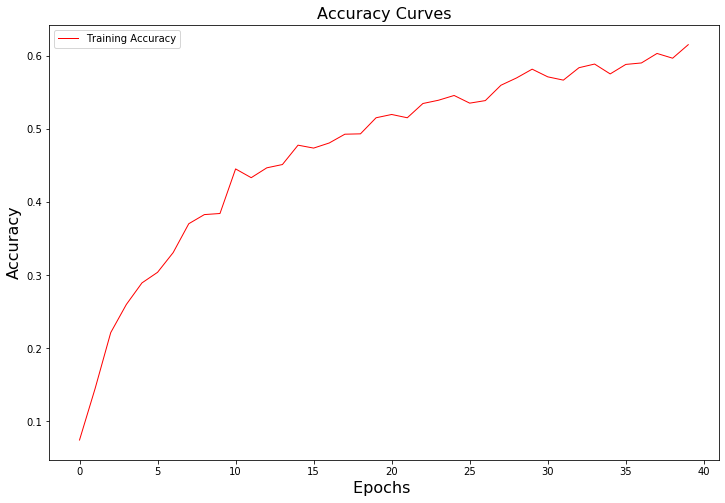

In [7]:
fig, ax = plt.subplots(figsize=[12,8])
ax.plot(model_history.history['accuracy'],'r',linewidth=1.0, label = 'Training Accuracy')
ax.legend()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### 4. Test accuracy

In [8]:
preds = model2.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

500/500 [==============================] - 0s 456us/step
Loss = 1.4307443332672118
Test Accuracy = 0.5400000214576721


### 5. Predicted label

In [9]:
predict_DATA_PATH = "../data/test_set_predict"
POINTS_FOLDER = os.path.join(predict_DATA_PATH, "points")

predict_points = read_points()

predict_start = time.time()
X_predict = np.zeros((predict_points.shape[0], 3003))
for i in range(predict_points.shape[0]):
    current = predict_points[i]
    X_predict[i,] = pdist(current)
predict_end = time.time()
print("Feature Extraction time on test set:","%s seconds"%(predict_end - predict_start))


Feature Extraction time on test set: 0.17246484756469727 seconds


In [27]:
y_predict = []
for i in model2.predict(X_predict):
    y_predict.append(np.argmax(i) + 1)

In [12]:
df_advance = pd.DataFrame(data = y_predict)
df_advance.to_csv('../output/baseline_prediction.csv')

In [25]:
df_baseline = pd.DataFrame(data = baseline_tune.predict(X_predict)) 
df_baseline.to_csv('../output/baseline_prediction1.csv')